In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim



from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

In [2]:
# 오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2), 
            nn.ReLU(),
            nn.Linear(2, 1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 2),
            nn.ReLU(),
            nn.Linear(2, 4), 
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [3]:
# 데이터 로드
data = pd.read_csv('./remove_outlier_dataset.csv', encoding='utf-8', index_col=0)
data["registration_time"] = pd.to_datetime(data["registration_time"])

# 사용할 특성 선택
features = ['count', 'cast_pressure', 'biscuit_thickness', 
            'upper_mold_temp1', 'upper_mold_temp2', 
            'lower_mold_temp1', 'lower_mold_temp2', 
            'sleeve_temperature']

normal_data = data[data["passorfail"] == 0][features]  # 정상 데이터
outlier_data = data[data["passorfail"] == 1][features]  # 이상치 데이터

# 정상 데이터만 정규화
scaler = RobustScaler()
normal_data_scaled = scaler.fit_transform(normal_data)

# 훈련 데이터와 테스트 데이터 분할 (정상 데이터만 사용)
X_train, X_test, y_train, y_test = train_test_split(
    normal_data_scaled,  # 정상 데이터만 사용
    np.zeros(len(normal_data_scaled)),  # 정상 데이터 레이블 (0)
    test_size=0.2, 
    random_state=42
)

# 테스트 데이터에 이상치 추가
# 먼저, 테스트 데이터도 스케일링
outlier_data_scaled = scaler.transform(outlier_data)
X_test_combined = np.vstack((X_test, outlier_data_scaled))
y_test_combined = np.concatenate((y_test, np.ones(len(outlier_data))))  # 이상치 레이블 (1)

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_combined, dtype=torch.float32)

# 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_156232\432801514.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./remove_outlier_dataset.csv', encoding='utf-8', index_col=0)


In [4]:
# 모델, 손실 함수, 최적화 알고리즘 정의
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 재구성 오류 계산
model.eval()
with torch.no_grad():
    reconstructed = model(X_test_tensor)
    mse = ((X_test_tensor - reconstructed) ** 2).mean(dim=1)  # 각 샘플에 대한 MSE 계산

# ROC 곡선과 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test_combined, mse.numpy())
roc_auc = auc(fpr, tpr)

# 최적의 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)  # Youden's J statistic
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')
print(f'ROC AUC: {roc_auc}')

# 최적의 임계값으로 예측
predictions = (mse.numpy() > optimal_threshold).astype(int)

# 평가지표 계산
print("Confusion Matrix:")
print(confusion_matrix(y_test_combined, predictions))
print("\nClassification Report:")
print(classification_report(y_test_combined, predictions, target_names=['Normal', 'Outlier']))

Epoch [10/100], Loss: 0.9369
Epoch [20/100], Loss: 1.2693
Epoch [30/100], Loss: 0.6911
Epoch [40/100], Loss: 1.5960
Epoch [50/100], Loss: 1.4307
Epoch [60/100], Loss: 1.1177
Epoch [70/100], Loss: 0.8433
Epoch [80/100], Loss: 1.1268
Epoch [90/100], Loss: 1.1884
Epoch [100/100], Loss: 1.4802
Optimal Threshold: 1.5176277160644531
ROC AUC: 0.8919559245853028
Confusion Matrix:
[[15178  2348]
 [  881  2984]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.87      0.90     17526
     Outlier       0.56      0.77      0.65      3865

    accuracy                           0.85     21391
   macro avg       0.75      0.82      0.78     21391
weighted avg       0.88      0.85      0.86     21391



AUC: 0.8919559245853028
Confusion Matrix:
[[15178  2348]
 [  881  2984]]


Text(50.722222222222214, 0.5, 'True Label')

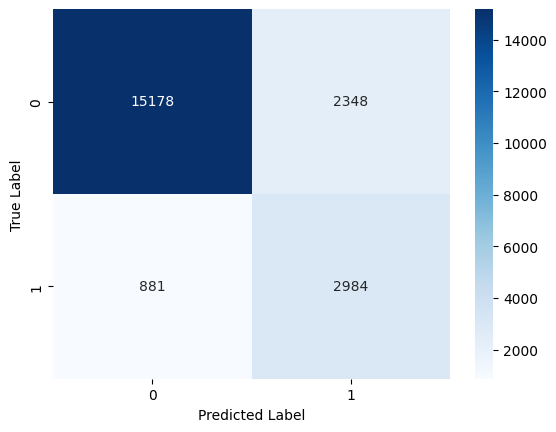

In [7]:
# 혼동 행렬
# y_pred = (y_pred_prob > 0.5).astype(int)  # 0.5를 기준으로 이진 분류
conf_matrix = confusion_matrix(y_test_tensor, predictions)

print(f'AUC: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')

# 혼동 행렬 시각화
# 시각화
sns.heatmap(conf_matrix, annot=True ,fmt='', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')